# Import Libraries

In [36]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pandas as pd
# Set pandas options to not truncate output
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
import numpy as np
import json
import os
import sys
import datetime

In [37]:
virtual_env_path = 'teamspace/uploads'
parent_directory = os.path.dirname(virtual_env_path)

print(f"Virtual environment directory: {virtual_env_path}")
print(f"Parent directory of the virtual environment folder: {parent_directory}")

Virtual environment directory: teamspace/uploads
Parent directory of the virtual environment folder: teamspace


In [38]:
print(datetime.datetime.now())

pd.set_option("mode.chained_assignment", None)

data_file_path = '/teamspace/uploads/hackathon_sample_v3.csv' # replace with the correct file name
factor_char_path = '/teamspace/uploads/factor_char_list.csv'  # replace with the correct file name

raw = pd.read_csv(data_file_path, parse_dates=["date"], low_memory=False)  # the date is the first day of the return month (t+1)

stock_vars = list(pd.read_csv(factor_char_path)["variable"].values)

2024-10-24 16:10:42.523870


In [39]:
factor_char_list = pd.read_csv(factor_char_path)
all_features_list = factor_char_list['variable'].to_list()
print(all_features_list)


['age', 'aliq_at', 'aliq_mat', 'ami_126d', 'at_be', 'at_gr1', 'at_me', 'at_turnover', 'be_gr1a', 'be_me', 'beta_60m', 'beta_dimson_21d', 'betabab_1260d', 'betadown_252d', 'bev_mev', 'bidaskhl_21d', 'capex_abn', 'capx_gr1', 'capx_gr2', 'capx_gr3', 'cash_at', 'chcsho_12m', 'coa_gr1a', 'col_gr1a', 'cop_at', 'cop_atl1', 'corr_1260d', 'coskew_21d', 'cowc_gr1a', 'dbnetis_at', 'debt_gr3', 'debt_me', 'dgp_dsale', 'div12m_me', 'dolvol_126d', 'dolvol_var_126d', 'dsale_dinv', 'dsale_drec', 'dsale_dsga', 'earnings_variability', 'ebit_bev', 'ebit_sale', 'ebitda_mev', 'emp_gr1', 'eq_dur', 'eqnetis_at', 'eqnpo_12m', 'eqnpo_me', 'eqpo_me', 'f_score', 'fcf_me', 'fnl_gr1a', 'gp_at', 'gp_atl1', 'intrinsic_value', 'inv_gr1', 'inv_gr1a', 'iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 'ivol_capm_21d', 'ivol_capm_252d', 'ivol_ff3_21d', 'ivol_hxz4_21d', 'kz_index', 'lnoa_gr1a', 'lti_gr1a', 'market_equity', 'mispricing_mgmt', 'mispricing_perf', 'ncoa_gr1a', 'ncol_gr1a', 'netdebt_me', 'netis_at', 'nfna_gr

# Dataset Normalization

In [40]:


ret_var = "stock_exret" # Define the left-hand side variable
new_set = raw[raw[ret_var].notna()].copy()


numeric_columns = new_set.select_dtypes(include=['float', 'int']).columns
new_set[numeric_columns] = new_set[numeric_columns].fillna(new_set[numeric_columns].median())
#print(new_set.dtypes)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
float_columns = new_set.select_dtypes(include=['float']).columns
float_factor_char_list = [col for col in all_features_list if col in float_columns]
new_set[float_factor_char_list] = scaler.fit_transform(new_set[float_factor_char_list])



In [41]:


def rename_column(col_name):
    if col_name in float_factor_char_list or col_name in float_factor_char_list:
        return f'feature_{col_name}'
    return col_name


new_set.columns = [rename_column(col) for col in new_set.columns]



# Feature columns preprocessing

# Cutoff for train/val/test split

In [42]:


starting = pd.to_datetime("20000101", format="%Y%m%d")
counter = 0
pred_out = pd.DataFrame()


cutoff = [
    starting,
    starting
    + pd.DateOffset(
        years=8 + counter
    ),  # use 8 years and expanding as the training set
    starting
    + pd.DateOffset(
        years=10 + counter
    ),  # use the next 2 years as the validation set
    starting + pd.DateOffset(years=24 + counter),
]  # use the next 10 years as the out-of-sample testing set


new_set["date"] = pd.to_datetime(new_set["date"].astype(str), format='%Y-%m-%d')



index_returns_path = '/teamspace/uploads/mkt_ind.csv'
spy = pd.read_csv(index_returns_path)
spy['date'] = pd.to_datetime(spy['year'].astype(str) + '-' + spy['month'].astype(str) + '-01')
spy["date"] = pd.to_datetime(spy["date"].astype(str), format='%Y-%m-%d')


new_set['date'] = pd.to_datetime(new_set['date'], format='%Y-%m-%d')  # Convert to datetime
new_set['year_month'] = new_set['date'].dt.to_period('M')  # Convert to 'YYYY-MM' format
print("step one done")
spy['year_month'] = spy['date'].dt.to_period('M')  # Convert to 'YYYY-MM' format
print("step two done")


# Perform a left join to add the 'sp_ret' column from 'spy_test' to 'test' based on 'date'
df_with_sp_ret = new_set.merge(spy[['year_month', 'sp_ret']], on='year_month', how='left')
print("step three done")



train = new_set[(new_set["date"] >= cutoff[0]) & (new_set["date"] < cutoff[1])]
valid = new_set[(new_set["date"] >= cutoff[1]) & (new_set["date"] < cutoff[2])]
test = new_set[(new_set["date"] >= cutoff[2]) & (new_set["date"] < cutoff[3])]
# Now you can perform the comparison with the cutoff timestamps
spy_train = spy[(spy["date"] >= cutoff[0]) & (spy["date"] < cutoff[1])]
spy_validate = spy[(spy["date"] >= cutoff[1]) & (spy["date"] < cutoff[2])]
spy_test = spy[(spy["date"] >= cutoff[2]) & (spy["date"] < cutoff[3])]

#print(spy.head(5))

# Display the updated 'test' dataframe with 'sp_ret' column
print(df_with_sp_ret.head())



step one done
step two done
step three done
   Unnamed: 0       date   ret_eom  permno  SHRCD  EXCHCD   mspread  year  \
0           0 2000-01-31  20000131   10001     11       3  0.031007  2000   
1           1 2000-01-31  20000131   10002     11       3  0.014570  2000   
2           2 2000-01-31  20000131   10009     11       3  0.015596  2000   
3           3 2000-01-31  20000131   10012     11       3  0.035910  2000   
4           4 2000-01-31  20000131   10016     11       3  0.014664  2000   

   month      RF  stock_exret stock_ticker     CUSIP       comp_name  \
0      1  0.0041    -0.048218          NaN       NaN             NaN   
1      1  0.0041    -0.029741          NaN       NaN             NaN   
2      1  0.0041    -0.012575          NaN       NaN             NaN   
3      1  0.0041    -0.101376          NaN       NaN             NaN   
4      1  0.0041    -0.103438         SCTT  81002230  SCOTT TECH INC   

   eps_medest  eps_meanest  eps_stdevest  eps_actual  featur

In [43]:
spy_test['sp_ret'].sum()

1.612838

In [44]:
train.head(2)

,Unnamed: 0,date,ret_eom,permno,SHRCD,EXCHCD,mspread,year,month,RF,stock_exret,stock_ticker,CUSIP,comp_name,eps_medest,eps_meanest,eps_stdevest,eps_actual,feature_prc,feature_market_equity,feature_div12m_me,feature_chcsho_12m,feature_eqnpo_12m,feature_ret_1_0,feature_ret_3_1,feature_ret_6_1,feature_ret_9_1,feature_ret_12_1,feature_ret_12_7,feature_ret_60_12,feature_seas_1_1an,feature_seas_1_1na,feature_seas_2_5an,feature_seas_2_5na,feature_at_gr1,feature_sale_gr1,feature_capx_gr1,feature_inv_gr1,feature_debt_gr3,feature_sale_gr3,feature_capx_gr3,feature_inv_gr1a,feature_lti_gr1a,feature_sti_gr1a,feature_coa_gr1a,feature_col_gr1a,feature_cowc_gr1a,feature_ncoa_gr1a,feature_ncol_gr1a,feature_nncoa_gr1a,feature_fnl_gr1a,feature_nfna_gr1a,feature_tax_gr1a,feature_be_gr1a,feature_ebit_sale,feature_gp_at,feature_cop_at,feature_ope_be,feature_ni_be,feature_ebit_bev,feature_netis_at,feature_eqnetis_at,feature_dbnetis_at,feature_oaccruals_at,feature_oaccruals_ni,feature_taccruals_at,feature_taccruals_ni,feature_noa_at,feature_opex_at,feature_at_turnover,feature_sale_bev,feature_rd_sale,feature_cash_at,feature_sale_emp_gr1,feature_emp_gr1,feature_ni_inc8q,feature_noa_gr1a,feature_ppeinv_gr1a,feature_lnoa_gr1a,feature_capx_gr2,feature_saleq_gr1,feature_niq_be,feature_niq_at,feature_niq_be_chg1,feature_niq_at_chg1,feature_rd5_at,feature_dsale_dinv,feature_dsale_drec,feature_dgp_dsale,feature_dsale_dsga,feature_saleq_su,feature_niq_su,feature_capex_abn,feature_op_atl1,feature_gp_atl1,feature_ope_bel1,feature_cop_atl1,feature_pi_nix,feature_ocf_at,feature_op_at,feature_ocf_at_chg1,feature_at_be,feature_ocfq_saleq_std,feature_tangibility,feature_earnings_variability,feature_aliq_at,feature_f_score,feature_o_score,feature_z_score,feature_intrinsic_value,feature_kz_index,feature_ni_ar1,feature_ni_ivol,feature_at_me,feature_be_me,feature_debt_me,feature_netdebt_me,feature_sale_me,feature_ni_me,feature_ocf_me,feature_fcf_me,feature_eqpo_me,feature_eqnpo_me,feature_rd_me,feature_bev_mev,feature_ebitda_mev,feature_aliq_mat,feature_eq_dur,feature_beta_60m,feature_resff3_12_1,feature_resff3_6_1,feature_mispricing_mgmt,feature_mispricing_perf,feature_ivol_capm_21d,feature_iskew_capm_21d,feature_coskew_21d,feature_beta_dimson_21d,feature_ivol_ff3_21d,feature_iskew_ff3_21d,feature_ivol_hxz4_21d,feature_iskew_hxz4_21d,feature_rmax5_21d,feature_rmax1_21d,feature_rvol_21d,feature_rskew_21d,feature_zero_trades_21d,feature_dolvol_126d,feature_dolvol_var_126d,feature_turnover_126d,feature_turnover_var_126d,feature_zero_trades_126d,feature_zero_trades_252d,feature_ami_126d,feature_ivol_capm_252d,feature_prc_highprc_252d,feature_betadown_252d,feature_bidaskhl_21d,feature_corr_1260d,feature_betabab_1260d,feature_rmax5_rvol_21d,age,feature_qmj,feature_qmj_prof,feature_qmj_growth,feature_qmj_safety,year_month
0,0,2000-01-31,20000131,10001,11,3,0.031007,2000,1,0.0041,-0.048218,NaN,NaN,NaN,0.11,0.11,0.03,0.11,-0.288217,-0.715091,0.576009,-0.005185,0.369370,-0.058817,0.213463,-0.039167,-0.066318,-0.177015,-0.238996,0.073576,-0.042530,-0.218538,-0.133045,-0.151464,-0.004096,-0.001814,-0.002835,-0.025797,-0.026663,-0.013475,-0.001913,-0.646484,-0.012908,0.009850,-0.087216,0.035285,-0.073849,0.045799,0.000939,0.049234,-0.077495,0.071409,0.048776,0.111818,0.001814,-0.123028,0.144437,0.005864,0.012305,0.023721,-0.044648,-0.102992,0.033324,-0.032785,0.002889,0.020567,-0.001434,-0.003966,0.104689,0.436423,-0.022287,-0.020043,-0.838842,-0.009421,0.008397,-0.443025,-0.004313,-0.003884,0.023357,-0.002941,-0.012008,0.004276,0.108018,0.004585,-0.002532,-0.156173,0.020342,0.004672,-0.005631,-0.004663,0.045077,0.089888,-0.001814,0.000767,-0.003964,0.004590,0.003111,-0.001814,0.199078,0.106122,0.002180,-0.011950,-0.065427,0.229891,-0.257268,-0.004998,0.813729,0.010102,-0.018395,-0.080224,0.021141,0.120834,-0.073194,-0.109864,-0.043360,-0.031418,0.003099,0.058603,0.080422,0.152404,0.095746,0.075309,0.123576,-0.051939,-0.005364,0.004738,0.093159,-0.023824,-0.870988,-0.460057,0.52770

In [45]:
valid.head(2)

,Unnamed: 0,date,ret_eom,permno,SHRCD,EXCHCD,mspread,year,month,RF,stock_exret,stock_ticker,CUSIP,comp_name,eps_medest,eps_meanest,eps_stdevest,eps_actual,feature_prc,feature_market_equity,feature_div12m_me,feature_chcsho_12m,feature_eqnpo_12m,feature_ret_1_0,feature_ret_3_1,feature_ret_6_1,feature_ret_9_1,feature_ret_12_1,feature_ret_12_7,feature_ret_60_12,feature_seas_1_1an,feature_seas_1_1na,feature_seas_2_5an,feature_seas_2_5na,feature_at_gr1,feature_sale_gr1,feature_capx_gr1,feature_inv_gr1,feature_debt_gr3,feature_sale_gr3,feature_capx_gr3,feature_inv_gr1a,feature_lti_gr1a,feature_sti_gr1a,feature_coa_gr1a,feature_col_gr1a,feature_cowc_gr1a,feature_ncoa_gr1a,feature_ncol_gr1a,feature_nncoa_gr1a,feature_fnl_gr1a,feature_nfna_gr1a,feature_tax_gr1a,feature_be_gr1a,feature_ebit_sale,feature_gp_at,feature_cop_at,feature_ope_be,feature_ni_be,feature_ebit_bev,feature_netis_at,feature_eqnetis_at,feature_dbnetis_at,feature_oaccruals_at,feature_oaccruals_ni,feature_taccruals_at,feature_taccruals_ni,feature_noa_at,feature_opex_at,feature_at_turnover,feature_sale_bev,feature_rd_sale,feature_cash_at,feature_sale_emp_gr1,feature_emp_gr1,feature_ni_inc8q,feature_noa_gr1a,feature_ppeinv_gr1a,feature_lnoa_gr1a,feature_capx_gr2,feature_saleq_gr1,feature_niq_be,feature_niq_at,feature_niq_be_chg1,feature_niq_at_chg1,feature_rd5_at,feature_dsale_dinv,feature_dsale_drec,feature_dgp_dsale,feature_dsale_dsga,feature_saleq_su,feature_niq_su,feature_capex_abn,feature_op_atl1,feature_gp_atl1,feature_ope_bel1,feature_cop_atl1,feature_pi_nix,feature_ocf_at,feature_op_at,feature_ocf_at_chg1,feature_at_be,feature_ocfq_saleq_std,feature_tangibility,feature_earnings_variability,feature_aliq_at,feature_f_score,feature_o_score,feature_z_score,feature_intrinsic_value,feature_kz_index,feature_ni_ar1,feature_ni_ivol,feature_at_me,feature_be_me,feature_debt_me,feature_netdebt_me,feature_sale_me,feature_ni_me,feature_ocf_me,feature_fcf_me,feature_eqpo_me,feature_eqnpo_me,feature_rd_me,feature_bev_mev,feature_ebitda_mev,feature_aliq_mat,feature_eq_dur,feature_beta_60m,feature_resff3_12_1,feature_resff3_6_1,feature_mispricing_mgmt,feature_mispricing_perf,feature_ivol_capm_21d,feature_iskew_capm_21d,feature_coskew_21d,feature_beta_dimson_21d,feature_ivol_ff3_21d,feature_iskew_ff3_21d,feature_ivol_hxz4_21d,feature_iskew_hxz4_21d,feature_rmax5_21d,feature_rmax1_21d,feature_rvol_21d,feature_rskew_21d,feature_zero_trades_21d,feature_dolvol_126d,feature_dolvol_var_126d,feature_turnover_126d,feature_turnover_var_126d,feature_zero_trades_126d,feature_zero_trades_252d,feature_ami_126d,feature_ivol_capm_252d,feature_prc_highprc_252d,feature_betadown_252d,feature_bidaskhl_21d,feature_corr_1260d,feature_betabab_1260d,feature_rmax5_rvol_21d,age,feature_qmj,feature_qmj_prof,feature_qmj_growth,feature_qmj_safety,year_month
375387,375387,2008-01-31,20080131,10001,11,3,0.021803,2008,1,0.0021,-0.008182,NaN,NaN,NaN,0.11,0.11,0.03,0.11,-0.073754,-0.680441,0.472169,-0.005716,0.475244,-0.057623,0.063415,-0.127709,-0.067333,0.288207,0.640037,0.155695,0.069711,0.313273,0.167127,0.287352,-0.004180,-0.001814,-0.002835,-0.013805,-0.027272,-0.016547,-0.001913,-0.016994,-0.011294,0.009850,-0.136013,-0.024927,-0.016102,-0.203710,-0.115160,-0.182669,-0.201421,0.185907,-0.031948,0.163891,0.001814,-0.096174,-0.093173,0.005673,0.012200,0.024961,-0.140950,-0.151544,-0.068712,0.243758,0.002889,0.262688,-0.001434,-0.004225,0.066362,0.288848,-0.018469,-0.020043,-0.323343,-0.013814,-1.128593,2.064080,-0.004449,-0.006417,-0.520958,-0.002941,-0.018396,0.002825,0.081556,0.002408,-0.007960,-0.156173,0.001732,0.005469,0.006163,-0.004663,0.024219,-0.040976,-0.001814,0.001022,-0.003874,0.004416,0.001254,-0.001814,0.013729,0.143882,-0.032596,-0.013429,-0.063039,0.598015,-0.227947,-0.005037,0.173767,-0.018794,-0.011983,-0.067800,0.020859,0.238463,-0.063070,-0.154574,-0.129287,-0.071659,-0.061252,-0.090328,0.075375,-0.020235,0.002433,0.221709,0.150253,-0.051939,-0.009914,0.005147,0.081634,-0.025866,-1.671932,1

In [46]:
test.head(2)

,Unnamed: 0,date,ret_eom,permno,SHRCD,EXCHCD,mspread,year,month,RF,stock_exret,stock_ticker,CUSIP,comp_name,eps_medest,eps_meanest,eps_stdevest,eps_actual,feature_prc,feature_market_equity,feature_div12m_me,feature_chcsho_12m,feature_eqnpo_12m,feature_ret_1_0,feature_ret_3_1,feature_ret_6_1,feature_ret_9_1,feature_ret_12_1,feature_ret_12_7,feature_ret_60_12,feature_seas_1_1an,feature_seas_1_1na,feature_seas_2_5an,feature_seas_2_5na,feature_at_gr1,feature_sale_gr1,feature_capx_gr1,feature_inv_gr1,feature_debt_gr3,feature_sale_gr3,feature_capx_gr3,feature_inv_gr1a,feature_lti_gr1a,feature_sti_gr1a,feature_coa_gr1a,feature_col_gr1a,feature_cowc_gr1a,feature_ncoa_gr1a,feature_ncol_gr1a,feature_nncoa_gr1a,feature_fnl_gr1a,feature_nfna_gr1a,feature_tax_gr1a,feature_be_gr1a,feature_ebit_sale,feature_gp_at,feature_cop_at,feature_ope_be,feature_ni_be,feature_ebit_bev,feature_netis_at,feature_eqnetis_at,feature_dbnetis_at,feature_oaccruals_at,feature_oaccruals_ni,feature_taccruals_at,feature_taccruals_ni,feature_noa_at,feature_opex_at,feature_at_turnover,feature_sale_bev,feature_rd_sale,feature_cash_at,feature_sale_emp_gr1,feature_emp_gr1,feature_ni_inc8q,feature_noa_gr1a,feature_ppeinv_gr1a,feature_lnoa_gr1a,feature_capx_gr2,feature_saleq_gr1,feature_niq_be,feature_niq_at,feature_niq_be_chg1,feature_niq_at_chg1,feature_rd5_at,feature_dsale_dinv,feature_dsale_drec,feature_dgp_dsale,feature_dsale_dsga,feature_saleq_su,feature_niq_su,feature_capex_abn,feature_op_atl1,feature_gp_atl1,feature_ope_bel1,feature_cop_atl1,feature_pi_nix,feature_ocf_at,feature_op_at,feature_ocf_at_chg1,feature_at_be,feature_ocfq_saleq_std,feature_tangibility,feature_earnings_variability,feature_aliq_at,feature_f_score,feature_o_score,feature_z_score,feature_intrinsic_value,feature_kz_index,feature_ni_ar1,feature_ni_ivol,feature_at_me,feature_be_me,feature_debt_me,feature_netdebt_me,feature_sale_me,feature_ni_me,feature_ocf_me,feature_fcf_me,feature_eqpo_me,feature_eqnpo_me,feature_rd_me,feature_bev_mev,feature_ebitda_mev,feature_aliq_mat,feature_eq_dur,feature_beta_60m,feature_resff3_12_1,feature_resff3_6_1,feature_mispricing_mgmt,feature_mispricing_perf,feature_ivol_capm_21d,feature_iskew_capm_21d,feature_coskew_21d,feature_beta_dimson_21d,feature_ivol_ff3_21d,feature_iskew_ff3_21d,feature_ivol_hxz4_21d,feature_iskew_hxz4_21d,feature_rmax5_21d,feature_rmax1_21d,feature_rvol_21d,feature_rskew_21d,feature_zero_trades_21d,feature_dolvol_126d,feature_dolvol_var_126d,feature_turnover_126d,feature_turnover_var_126d,feature_zero_trades_126d,feature_zero_trades_252d,feature_ami_126d,feature_ivol_capm_252d,feature_prc_highprc_252d,feature_betadown_252d,feature_bidaskhl_21d,feature_corr_1260d,feature_betabab_1260d,feature_rmax5_rvol_21d,age,feature_qmj,feature_qmj_prof,feature_qmj_growth,feature_qmj_safety,year_month
453680,453680,2010-01-29,20100131,10001,11,2,0.007080,2010,1,0.0,-0.018932,NaN,NaN,NaN,0.11,0.11,0.03,0.11,-0.219772,-0.672986,0.507773,-0.005147,0.374843,0.713377,0.093434,0.04252,0.100496,0.056349,0.022556,0.443440,0.122079,0.264117,-0.266923,0.470128,-0.004062,-0.001814,-0.002835,-0.022325,-0.026742,-0.015492,-0.001913,-0.400618,0.015771,0.35191,-0.281717,-0.01845,-0.074056,0.083808,-0.014820,0.096171,0.101323,0.039413,-0.008155,0.134186,0.001814,-0.070441,0.045912,0.007066,0.012677,0.024970,-0.006989,-0.102204,0.179972,0.145491,0.002889,0.114050,-0.001434,-0.003967,0.128475,0.589169,-0.020211,-0.020043,-0.461979,-0.011966,-0.043878,-0.443025,-0.004267,-0.003616,-0.071249,-0.002941,-0.023397,0.004574,0.127496,0.004825,0.000095,-0.156173,0.007765,0.005390,0.001129,-0.004663,-0.007045,0.008289,-0.001814,0.002222,-0.003447,0.006020,0.002465,-0.001814,0.100653,0.180068,-0.002431,-0.013317,-0.063325,0.051867,-0.075823,-0.004883,0.173767,-0.014726,-0.011887,-0.050269,0.020067,-0.037322,-0.05299,-0.146909,-0.100178,-0.066932,-0.052644,-0.036645,0.082512,0.035316,0.049162,-0.116609,0.061762,-0.051939,-0.006095,0.005774,0.310024,-0.015862,-1.151001,-0.053904,0.377

# Target = "stock_exret"

# Neural Network

Epoch 1/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3312 - mean_squared_error: 0.3312 - val_loss: 0.0730 - val_mean_squared_error: 0.0730
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1146 - mean_squared_error: 0.1146 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0777 - mean_squared_error: 0.0777 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - val_loss: 0.0517 - val_mean_squared_error: 0.0517
Epoch 5/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 6/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 7/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - 

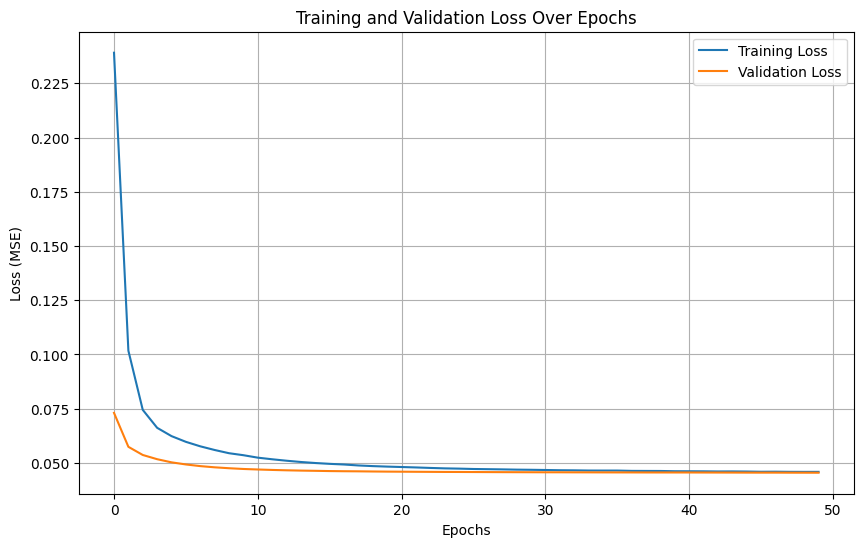

2347/2347 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step
[-0.0577578   0.02559448 -0.00170662 ...  0.01457381  0.01416064
 -0.01822014]


In [47]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings and info logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = info, 2 = warnings, 3 = errors

# Assuming 'train' DataFrame contains your data
X = train.filter(like="feature_")  # Features (all columns that start with "feature_")
Y = train["stock_exret"]  # Target (stock expected returns)

# Split the data into training and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the Neural Network model for regression
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))

# Output layer with linear activation for regression
model.add(Dense(1, activation='linear'))

# Compile the model with 'mean_squared_error' loss and Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])




# Train the model with the learning rate schedule
history = model.fit(X_train, Y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(X_valid, Y_valid),
                    verbose=1)


# Plot training & validation loss to visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Assuming X_test is prepared and scaled
predictions = model.predict(X_valid)

# Save the final trained model
model.save('final_model.keras')

# Compute the quality scores (mean prediction value for each row)
quality_scores = np.mean(predictions, axis=1)

# Create a DataFrame for the quality scores and save as a CSV
test_quality_scores = pd.DataFrame({'quality_score': quality_scores})
test_qs_path = 'quality_scores.csv'
test_quality_scores.to_csv(test_qs_path, index=False)

# Print the quality scores for inspection
print(quality_scores)


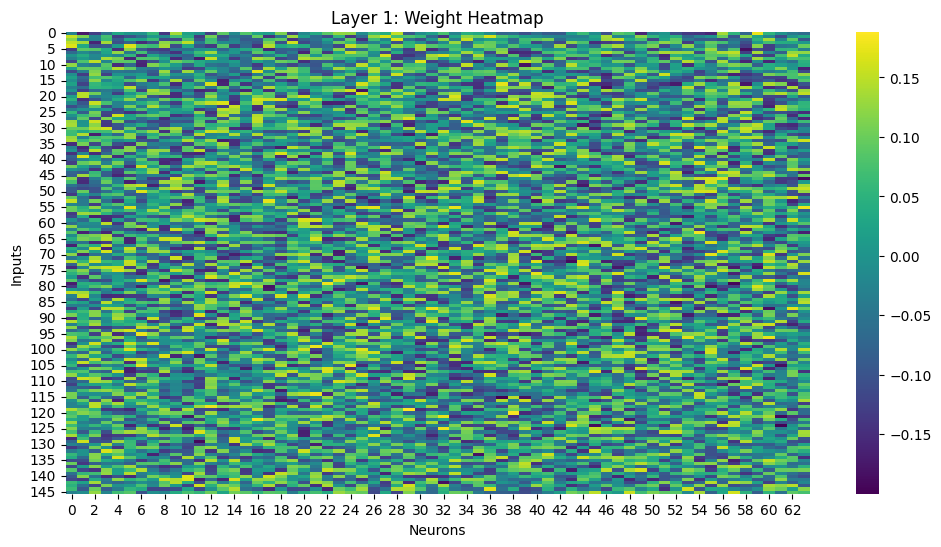

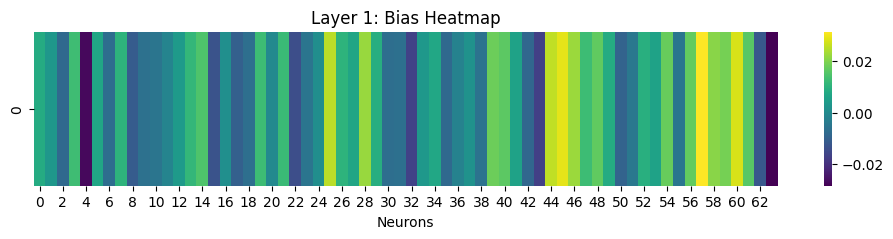

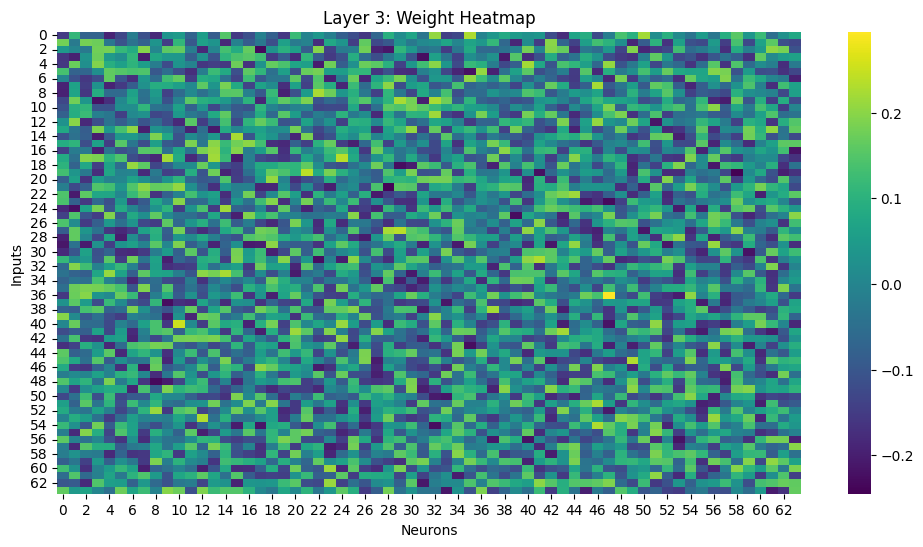

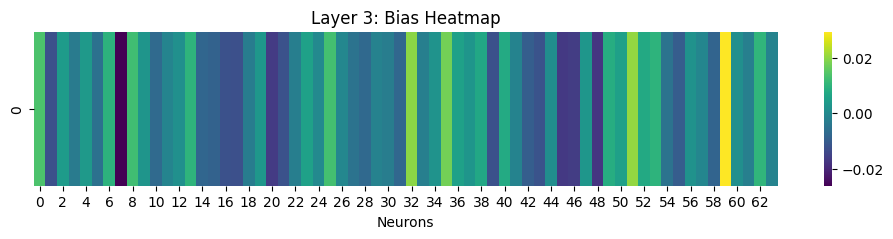

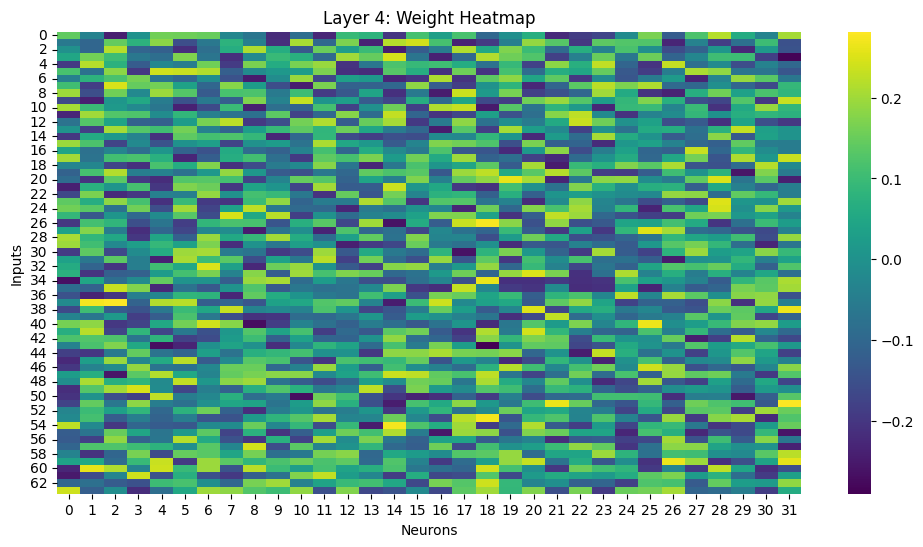

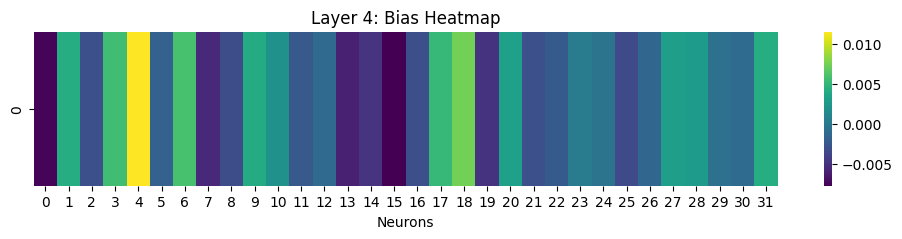

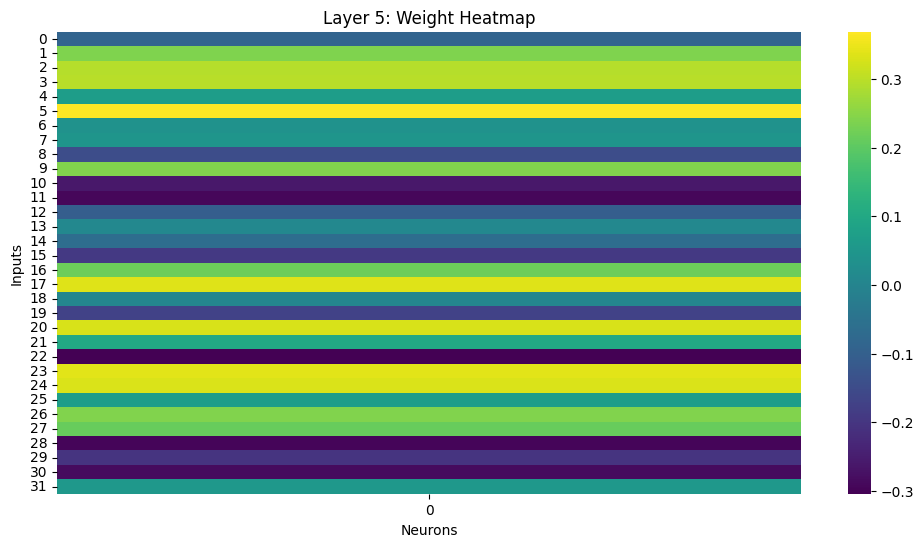

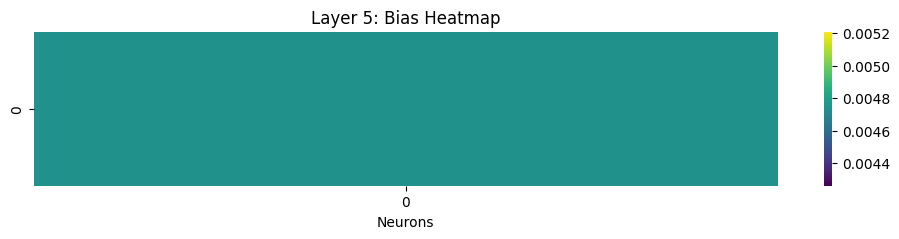

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('final_model.keras')

# Iterate over each layer in the model
for i, layer in enumerate(model.layers):
    # Check if the layer has weights (Dense, Conv layers have weights, while Activation, Dropout, etc., do not)
    if len(layer.get_weights()) > 0:
        weights, biases = layer.get_weights()  # Get weights and biases

        # Plot weight heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(weights, cmap='viridis', annot=False)
        plt.title(f'Layer {i + 1}: Weight Heatmap')
        plt.xlabel('Neurons')
        plt.ylabel('Inputs')
        plt.show()

        # Optionally plot bias heatmap
        if biases is not None:
            plt.figure(figsize=(12, 2))
            sns.heatmap(biases.reshape(1, -1), cmap='viridis', annot=False)
            plt.title(f'Layer {i + 1}: Bias Heatmap')
            plt.xlabel('Neurons')
            plt.show()


In [49]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
model = tf.keras.models.load_model('final_model.keras')

# Assuming the features start with "feature_" as in the training data
X_test = test.filter(like="feature_")
predictions = model.predict(X_test)

# quality score
test['predictions'] = predictions


test.to_csv("test_predictions.csv")
print(len(test))

13606/13606 ━━━━━━━━━━━━━━━━━━━━ 10s 729us/step
435391


In [50]:
updated_permno_list = 'updated_matched_ticker_cik.csv'
permno_list_df = pd.read_csv(updated_permno_list)
permno_list = permno_list_df['permno']

test_filtered = test[test['permno'].isin(permno_list)]

test = test_filtered
print(len(test))
test.to_csv('final_test.csv')

152415


# Momentum

In [51]:


from scipy.stats import mstats
momentum = test[['date', 'year', 'permno', 'feature_ret_12_1']]
momentum['momentum_winsorized'] = mstats.winsorize(momentum['feature_ret_12_1'], limits=[0.01, 0.01])


scaler = StandardScaler()
momentum['momentum_normalized_zscore'] = scaler.fit_transform(momentum[['momentum_winsorized']])


momentum['momentum_zscore_trimmed'] = momentum['momentum_normalized_zscore'].where(
    (momentum['momentum_normalized_zscore'] >= -3) & (momentum['momentum_normalized_zscore'] <= 3),
    other=0
)

print(len(momentum))
# Display the first few rows to verify
momentum.head()


test['alpha_momentum'] = momentum['momentum_zscore_trimmed']

152415


In [60]:
test['alpha'] = (test['alpha_momentum'] + test['predictions']) / 2

test.to_csv('test.csv')

In [53]:
class StockAnalyzer:
    def __init__(self, stock_data):
        """
        Initialize the StockAnalyzer with stock data.
        :param stock_data: pandas DataFrame containing 'permno', 'date', 'alpha', and other columns.
        """
        self.stock = stock_data
        self.port_returns = []

    def get_top_100(self, month_year):
        """
        Order the stocks by alpha and select the top 100 stocks for the given month.
        :param month_year: The month-year string in 'YYYY-MM' format for filtering the data.
        :return: A list of top 100 permnos for the given month_year.
        """
        # Filter stocks for the specific month_year
        temp_stock_data = self.stock[self.stock['year_month'] == month_year]
        len(temp_stock_data)
        # Sort stocks by alpha score in descending order and select top 100
        temp_stock_data_sorted = temp_stock_data.sort_values(by='alpha', ascending=False).head(100)

        stock_exret_mean = temp_stock_data_sorted['stock_exret'].mean()

        self.port_returns.append(stock_exret_mean)
        # Extract the 'permno' values of the top 100 stocks
        top_100_permnos = temp_stock_data_sorted['permno'].tolist()
        # Return the list of top 100 permnos
        return top_100_permnos
    
    def get_portfolio_returns(self):
        return self.port_returns


# Assuming df is your stock data DataFrame with 'date', 'alpha', and 'permno' columns
pdf = test
# Parse 'date' column into datetime and extract 'year_month'
pdf['date'] = pd.to_datetime(pdf['date'], format='%Y-%m-%d')  # Convert to datetime
pdf['year_month'] = pdf['date'].dt.to_period('M')  # Convert to 'YYYY-MM' format
# Get unique 'year_month' values
year_month_list = pdf['year_month'].unique()
# Initialize the StockAnalyzer with the stock data DataFrame
stock_analyzer = StockAnalyzer(pdf)
# Initialize an empty set to store permnos that have ever been in the top 100
all_top_100_permnos = set()
# Loop through each unique year_month and get the top 100 permnos
for year_month in year_month_list:
    top_100_permnos = stock_analyzer.get_top_100(year_month)
    # Add the top 100 permnos of this month to the set (set automatically avoids duplicates)
    all_top_100_permnos.update(top_100_permnos)
    # Optional: print the permnos for the current month
    #print(f"Top 100 permnos for {year_month}: {len(top_100_permnos)}")
    #print(f"ALL top 100 permnos for {year_month}: {len(all_top_100_permnos)}")

# After the loop, print the total set of permnos that have ever been in the top 100
print(f"All permnos that have ever been in the top 100: {len(all_top_100_permnos)}")
print(f"Total unique permnos: {len(all_top_100_permnos)}")
portfolio_returns = stock_analyzer.get_portfolio_returns()


All permnos that have ever been in the top 100: 1276
Total unique permnos: 1276


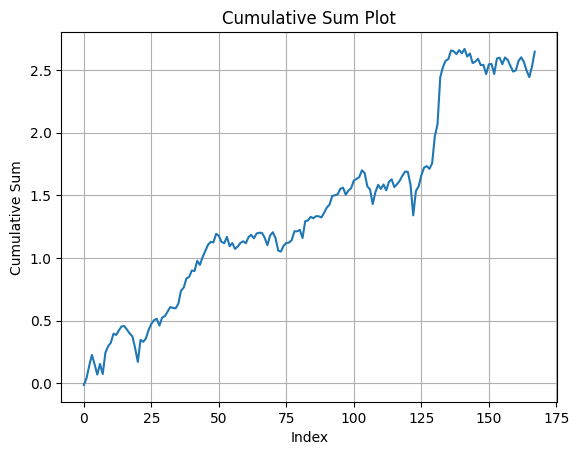

In [54]:
import matplotlib.pyplot as plt
import numpy as np

index_returns_path = '/teamspace/uploads/mkt_ind.csv'
index_returns = pd.read_csv(index_returns_path)

# Compute the cumulative sum of the list
cumsum_numbers = np.cumsum(portfolio_returns)

# Generate the plot
plt.plot(cumsum_numbers)


# Add title and labels
plt.title('Cumulative Sum Plot')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.show()


SEC ALPHA

In [55]:



import pandas as pd

# Initialize 'sec_alpha' in the 'test' dataframe with 1s
test['sec_alpha'] = 1

# Convert 'year_month' in 'test' to string format 'YYYY-MM'
test['year_month'] = test['year_month'].astype(str)

# Ensure 'Date' in 'permno_df' is in 'YYYY-MM' format
permno_df['Date'] = pd.to_datetime(permno_df['Date']).dt.to_period('M').astype(str)

# Loop through the rows in 'test' dataframe using .iloc for positional access
for i in range(len(test)):
    test_permno = test.iloc[i]['permno']  # Get permno from test using .iloc
    test_year_month = test.iloc[i]['year_month']  # Get year_month from test using .iloc

    # Loop through 'permno_df' and find matching rows
    for j in range(len(permno_df)):
        permno_df_permno = permno_df.iloc[j]['PERMNO']  # Get PERMNO from permno_df using .iloc
        permno_df_date = permno_df.iloc[j]['Date']  # Get Date (year_month) from permno_df using .iloc

        # Check if both permno and year_month match
        if test_permno == permno_df_permno and test_year_month == permno_df_date:
            # Update 'sec_alpha' in 'test' with the 'sec_alpha' from 'permno_df'
            test.at[i, 'sec_alpha'] = permno_df.iloc[j]['sec_alpha']
            break  # Exit inner loop once a match is found for this row


KeyError: 0

In [ ]:
# Convert the set to a list
my_list = list(all_top_100_permnos)

# Save the list as a JSON file
with open('all_top_100_permnos.json', 'w') as json_file:
    json.dump(my_list, json_file)

# Optional: print the list to verify
print(my_list)

[90129, 16417, 65584, 90178, 90210, 90249, 57509, 49322, 16555, 82107, 57534, 65752, 82156, 82163, 82171, 82176, 90377, 16655, 82196, 41241, 82212, 82231, 90440, 82266, 82272, 82281, 82287, 33137, 24951, 82298, 90544, 33209, 57808, 57817, 66050, 82504, 82508, 82513, 82518, 82521, 82526, 82530, 90730, 82542, 82544, 82546, 82547, 82552, 82567, 82571, 82573, 82575, 90776, 82587, 82599, 82607, 82621, 17090, 82635, 82639, 82640, 17107, 82644, 25304, 82664, 82668, 82670, 17137, 33532, 82699, 82702, 90916, 82747, 66368, 82762, 82763, 82768, 82779, 50017, 25452, 25487, 82831, 82839, 82855, 82859, 17372, 82932, 33823, 58421, 33849, 50243, 42059, 42067, 74836, 50286, 17523, 74908, 83112, 83123, 83145, 83148, 83149, 83155, 17671, 75033, 66852, 83239, 83244, 42286, 58675, 75070, 83272, 83291, 75101, 75104, 75107, 83317, 42358, 83333, 75182, 83382, 67002, 83391, 42439, 83399, 75215, 58836, 67029, 83414, 42455, 83413, 75222, 83421, 83422, 75233, 26084, 75261, 83462, 75272, 83469, 17961, 83503, 75316

Index(['year_month', 'Unnamed: 0.1', 'Unnamed: 0', 'date', 'ret_eom', 'permno',
       'SHRCD', 'EXCHCD', 'mspread', 'year',
       ...
       'feature_qmj', 'feature_qmj_prof', 'feature_qmj_growth',
       'feature_qmj_safety', 'predictions', 'alpha_momentum', 'alpha',
       'sec_alpha', 'stock_exret_std', 'std'],
      dtype='object', length=173)
Processing for date: 2010-01
Optimized weights for 2010-01: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-02
Optimized weights for 2010-02: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-03
Optimized weights for 2010-03: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-04
Optimized weights for 2010-04: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-05
Optimized weights for 2010-05: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-06
Optimized weights for 2010-06: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-07
Optimized weights for 2010-07: [0. 0. 0. ... 0. 0. 0.]
Processing for date: 2010-08
Optimized weights for 2010-08: 

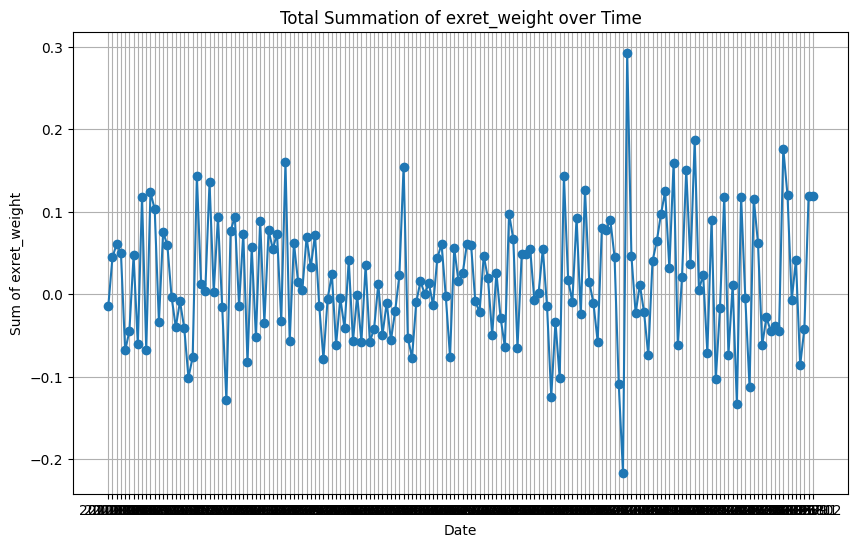

In [118]:
# PRAVEEN SECTION

import cvxpy as cp
import numpy as np
import pandas as pd

class StockPicker:
    
    def __init__(self, stock_data, indx_data):
        """
        Initialize the StockPicker class with the data.
        """

        self.stock = stock_data  # Stock data with permno, alpha, beta, stock_exret, etc.
        self.indx = indx_data  # Index data (optional, depending on how you're using it)

        # Extract permno from the stock data to initialize the number of stocks
        self.n_stocks = len(stock_data['permno'].unique())
        print(self.stock.columns)
        # Check if 'alpha' is in the stock_data DataFrame
        if 'alpha' not in self.stock.columns:
            print("Error: 'alpha' column not found in stock_data. Please ensure it is properly calculated and included.")
        else:
        # Proceed with your code if 'alpha' exists
            alpha = test['alpha'].values


    def optimize_weights(self, w_prev, current_date):
        """
        Optimize stock portfolio weights for a given date.

        Parameters:
        - w_prev: The portfolio weights from the previous month.
        - current_date: The date for which the optimization is being done.

        Returns:
        - Optimized portfolio weights for the given date.
        """

        # Filter stock data for the current date
        temp_stock = self.stock[self.stock['year_month'] == current_date]
        current_permnos = temp_stock['permno'].values

        # Ensure the dimensions of temp_stock are correct
        if len(temp_stock) == 0:
            raise ValueError(f"No stock data available for {current_date}.")

        # Get the alphas and betas for the current stocks at the given date
        alpha = temp_stock['alpha'].values  # Assuming 'alpha' is in the stock data for that date
        beta = temp_stock['feature_beta_60m'].values  # Assuming 'beta' is in the stock data
        std = temp_stock['stock_exret_std'].values

        # Ensure alpha and beta are of correct shape
        if len(alpha) == 0 or len(beta) == 0:
            raise ValueError(f"Alpha or beta values are not available for {current_date}.")

        # Allowable weight values (from 0 to 0.1 in steps of 0.01)
        weight_levels = np.arange(0, 0.11, 0.01)
        n_levels = len(weight_levels)

        # Adjust binary variables for the current number of stocks
        b = cp.Variable((len(temp_stock), n_levels), boolean=True)
        w = b @ weight_levels  # Portfolio weights as a sum of binary variables multiplied by their corresponding weight values
        z = cp.Variable(len(temp_stock), boolean=True)  # Binary variables for stock inclusion

        # Small slack variable to handle the case where w_prev == 0
        epsilon = 1e-6

        # Objective: Maximize total alpha score for the current date's stocks
        objective = cp.Maximize(cp.sum(cp.multiply(alpha, w)))

        # Constraints
        constraints = []
        constraints.append(cp.sum(w) >= 0.9)  # Total weight should be at least 50%
        constraints.append(cp.sum(w) <= 1)  # Total weight should be at most 100%
        constraints.append(w <= 0.10)  # Maximum weight constraint for any stock (10%)
        constraints.append(cp.sum(z) >= 90)  # Minimum portfolio size (50 stocks)
        constraints.append(cp.sum(z) <= 100)  # Maximum portfolio size (100 stocks)
        constraints.append(w <= z + epsilon)  # Weight inclusion constraint
        constraints.append(cp.sum(b, axis=1) == z)  # Each stock is assigned exactly one weight level
        constraints.append(cp.sum(cp.multiply(w,std)) <= 0.16)

        # Turnover constraint
        turnover_limit = 0.25
        constraints.append(cp.sum(cp.abs(w - w_prev)) <= turnover_limit)

        # Beta constraint
        max_portfolio_beta = 1.0
        portfolio_beta = cp.sum(cp.multiply(beta, w))  # Portfolio beta
        constraints.append(portfolio_beta <= max_portfolio_beta)

        # Solve the optimization problem
        prob = cp.Problem(objective, constraints)
        prob.solve()

        # Return the optimized portfolio weights
        return w.value



            

    def optimize_by_date_range(self):
        """
        Loop through each month in the date range and optimize weights for each.
        Track weights along with permno, date, stock_exret, and the product of stock_exret * weight.
        """
        init_flag = 0
        # Extract unique months from the stock data within the given range
        unique_dates = self.stock['year_month'].unique()

        # Initialize variables to store weight history and stock_exret * weight summation
        weight_history = []  # This will hold records with permno, date, weight, and stock_exret
        exret_weight_summation = []  # To store the sum of stock_exret * weight per date

        w_prev_feed = None

        # Loop through each date and run optimization
        for i, date in enumerate(unique_dates):
            print(f"Processing for date: {date}")
        
            # Filter stocks for the current period
            temp_stock = self.stock[self.stock['year_month'] == date]
            current_permnos = temp_stock['permno'].values
            current_exret = temp_stock['stock_exret'].values  # Get the corresponding stock_exret values

            if init_flag == 0:  # first month initialization
                w_prev = np.zeros(len(temp_stock))  # Initialize previous weights as zeros
                top_100_indices = np.argsort(temp_stock['alpha'].values)[-100:]
                w_prev[top_100_indices] = 0.01  # Buy 1% weight in the top 100 performing stocks
                optimized_weights = self.optimize_weights(w_prev, date)
                w_prev_feed = optimized_weights.copy()  # Initialize w_prev_feed after the first optimization

                # Calculate stock_exret * weight
                stock_exret_weight = current_exret * optimized_weights

                # Store the permno, date, weight, stock_exret, and the stock_exret * weight
                weight_history.append(pd.DataFrame({
                    'permno': current_permnos,
                    'year_month': date,
                    'weight': optimized_weights,
                    'stock_exret': current_exret,
                    'exret_weight': stock_exret_weight
                }))
                # Summation of exret_weight for the first period
                exret_weight_summation.append({'year_month': date, 'exret_weight_sum': stock_exret_weight.sum()})
                print(f"Optimized weights for {date}: {optimized_weights}")
                init_flag = 1
            else:
                prev_date_index = i - 1  # Using the loop index to access the previous date

                if prev_date_index >= 0:
                    prev_date = unique_dates[prev_date_index]
                    prev_stock = self.stock[self.stock['year_month'] == prev_date]
                    prev_permnos = prev_stock['permno'].values
                    aligned_w_prev_feed = np.zeros(len(temp_stock))

                    # Ensure w_prev_feed is not None before using it
                    if w_prev_feed is None:
                        raise ValueError(f"w_prev_feed is None at {prev_date}. Ensure it is properly initialized.")

                    # Align previous weights with current stocks
                    for i, permno in enumerate(current_permnos):
                        if permno in prev_permnos:
                            prev_index = np.where(prev_permnos == permno)[0][0]
                            aligned_w_prev_feed[i] = w_prev_feed[prev_index]
                        else:
                            aligned_w_prev_feed[i] = 0  # Stock wasn't in the previous month

                    # Optimize weights for the current period
                    optimized_weights = self.optimize_weights(aligned_w_prev_feed, date)

                    # Calculate stock_exret * weight
                    stock_exret_weight = temp_stock['stock_exret'].values * optimized_weights

                    w_prev_feed = optimized_weights.copy()  # Update previous weights after optimization

                    weight_history.append(pd.DataFrame({
                        'permno': current_permnos,
                        'year_month': date,
                        'weight': optimized_weights,
                        'stock_exret': temp_stock['stock_exret'].values,
                        'exret_weight': stock_exret_weight
                    }))

                    exret_weight_summation.append({'year_month': date, 'exret_weight_sum': stock_exret_weight.sum()})
                    print(f"Optimized weights for {date}: {optimized_weights}")

        # Concatenate all weight history into a single DataFrame
        weight_history_df = pd.concat(weight_history, ignore_index=True)

        # Create DataFrame for the exret_weight summation
        exret_weight_sum_df = pd.DataFrame(exret_weight_summation)

        # Plot the total exret_weight summation over time
        plt.figure(figsize=(10, 6))
        plt.plot(exret_weight_sum_df['year_month'], exret_weight_sum_df['exret_weight_sum'], marker='o')
        plt.title('Total Summation of exret_weight over Time')
        plt.xlabel('Date')
        plt.ylabel('Sum of exret_weight')
        plt.grid(True)
        plt.show()

        # Optionally return the weight history and exret_weight summation DataFrame
        return {
            'w_history': weight_history_df,
            'exret_weight_sum_df': exret_weight_sum_df
        }
    



if __name__ == "__main__":
    # Example stock data with permno, date, alpha, and beta columns (use your actual data here)
    stock_data = pd.read_csv('test.csv')
    #beta_std_set = beta_std_set[['stock_exret']].fillna(0)

    # Compute rolling standard deviation per 'permno'
    stock_data.set_index('year_month', inplace=True)
    stock_std = stock_data.groupby('permno')['stock_exret'].rolling(window=60, min_periods=24).std().reset_index()

    # Calculate average standard deviation for each 'year_month'
    avg_month = stock_data.groupby('year_month')['stock_exret'].mean()

    # Merge the rolling std back into the stock_data
    stock_data = stock_data.reset_index()  # Reset index to merge correctly
    stock_data = stock_data.merge(stock_std[['permno', 'year_month', 'stock_exret']], on=['permno', 'year_month'], how='left', suffixes=('', '_std'))

    # Fill missing std values with average by month
    stock_data['stock_exret_std'].fillna(stock_data['year_month'].map(avg_month), inplace=True)
    stock_data['std'] = stock_data['stock_exret_std'].values

    indx_data = None  # Placeholder for index data

    # Initialize the StockPicker class
    picker = StockPicker(stock_data, indx_data)

    # Optimize weights for the date range '2020-01-01' to '2020-02-01'
    x = picker.optimize_by_date_range()


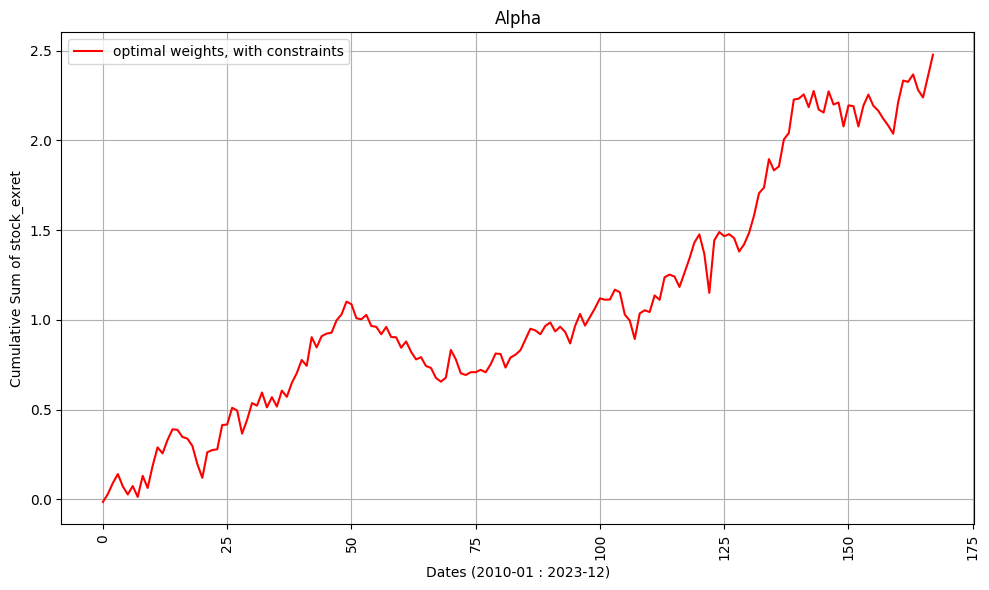

In [134]:

exret_weight_sum_df = x['exret_weight_sum_df']
# Assuming the DataFrame is named `exret_weight_sum_df`
exret_weight_sum_df.to_csv('optimized_portfolio.csv', index=False)


import matplotlib.pyplot as plt

# Calculate the cumulative sum
cumsum_values = exret_weight_sum_df['exret_weight_sum'].cumsum()

# Plot the cumulative sum
plt.figure(figsize=(10, 6))

# Plot the values with different colors and labels for the legend
plt.plot(cumsum_values, color='red', label='optimal weights, with constraints')
#plt.plot(cumsum_numbers, color='blue', label='equal weights, no constraints')

# Add title and labels
plt.title('Alpha')
plt.xlabel('Dates (2010-01 : 2023-12)')
plt.ylabel('Cumulative Sum of stock_exret')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a grid for readability
plt.grid(True)

# Tight layout to adjust margins
plt.tight_layout()

# Show the plot
plt.show()


In [124]:
pd.Series(portfolio_returns).std() * np.sqrt(12)

0.23130379472283183

In [127]:
pf_rsk = exret_weight_sum_df['exret_weight_sum'].std() * np.sqrt(12)
pf_rsk

0.25796931401731615

In [130]:
spy_rsk = spy['sp_ret'].std() * np.sqrt(12)
spy_rsk

0.15352812652307712

In [129]:
(spy_rsk+0.01)/pf_rsk

0.6339053431451941

In [136]:

# Compute rolling standard deviation for 'exret_weight_sum' with a window of 12
stock_std = exret_weight_sum_df['exret_weight_sum'].rolling(window=12, min_periods=2).std()

# Compute rolling standard deviation for 'sp_ret' with a window of 24
sp_std = spy_test['sp_ret'].rolling(window=24).std()

# Reset the index of the resulting Series
sp_std_reset = sp_std.reset_index(drop=True)

# Apply shift to sp_std values
sp_std_shifted = sp_std_reset.shift(1)

# Display the results
print(sp_std_shifted.head())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: sp_ret, dtype: float64


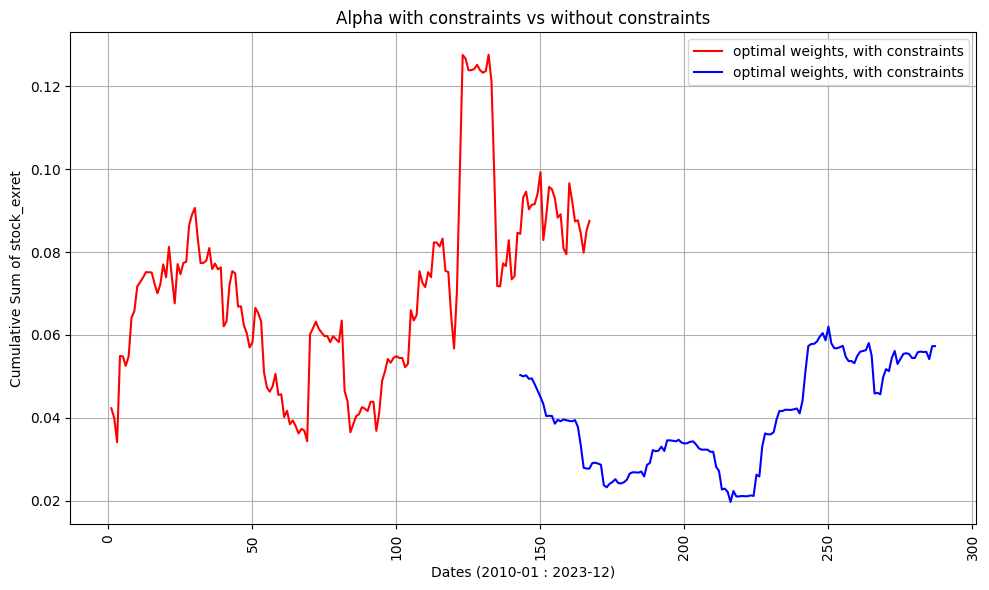

In [137]:
plt.figure(figsize=(10, 6))

# Plot the values with different colors and labels for the legend
plt.plot(stock_std, color='red', label='optimal weights, with constraints')
plt.plot(sp_std, color='blue', label='optimal weights, with constraints')


# Add title and labels
plt.title('Alpha with constraints vs without constraints')
plt.xlabel('Dates (2010-01 : 2023-12)')
plt.ylabel('Cumulative Sum of stock_exret')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a grid for readability
plt.grid(True)

# Tight layout to adjust margins
plt.tight_layout()

# Show the plot
plt.show()
